Final Project
Week 5: Capstone Project

[Course: Applied Data Science Capstone](https://www.coursera.org/learn/applied-data-science-capstone)



In [1]:
#imports section
import numpy as np
import pandas as pd
import requests
import  folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

#Params FourSquare
CLIENT_ID = 'TRGLOYAOAFILBLJXIOSZPEKOVZVKHDM5EKMGPHFKZ2KRBHQH' # your Foursquare ID
CLIENT_SECRET = 'SDTSNNBJ2ZHMIAAMU1IO3VC1QZ0S03OBXI22FDAOGPK5PL0A' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version



Loading data

In [2]:
#url='https://datos.madrid.es/egob/catalogo/200078-1-distritos-barrios.csv'
url='https://datos.madrid.es/egob/catalogo/200078-4-distritos-barrios.csv'
dfDistrito=pd.read_csv(url,delimiter=';',encoding = "ISO-8859-1")
dfDistrito.head()


,Perimetro (m),Codigo de distrito,Nombre de distrito,Nombre acentuado del distrito,Numero de barrios,Superficie (m2)
0,10304,1,CENTRO,CENTRO,6,5231264
1,12834,2,ARGANZUELA,ARGANZUELA,7,6466400
2,9523,3,RETIRO,RETIRO,6,5465307
3,10862,4,SALAMANCA,SALAMANCA,6,5387243
4,13401,5,CHAMARTIN,CHAMARTÍN,6,9170122


In [3]:
#loading latitudes and longitudes
from geopy.geocoders import Nominatim
address = ',Madrid,Spain'
latitude=[]
longitude=[]
for i in dfDistrito['Nombre de distrito']:
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(i+address)
    latitude.append(location.latitude)
    longitude.append(location.longitude)


In [4]:
dfDistrito.drop(columns=['Perimetro (m)','Nombre acentuado del distrito', 'Numero de barrios', 'Superficie (m2)'],inplace=True)
dfDistrito.insert(2,"Latitude",latitude,True)
dfDistrito.insert(3,"Longitude",longitude,True)
dfDistrito.head()

,Codigo de distrito,Nombre de distrito,Latitude,Longitude
0,1,CENTRO,40.417653,-3.707914
1,2,ARGANZUELA,40.398068,-3.693734
2,3,RETIRO,40.411150,-3.676057
3,4,SALAMANCA,40.427045,-3.680602
4,5,CHAMARTIN,40.458987,-3.676129


Explore Neighborhoods in Madrid

In [5]:
#list of category from FourSquare
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION)
# make the GET request
results = requests.get(url).json()['response']['categories']

categories = []
for x in results:
    y = x['categories']
    for subcategory in y:
        categories.append(subcategory['name'])

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT=500):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Neighborhood Latitude',
                  'Neighborhood Longitude',
                  'Venue',
                  'Venue Latitude',
                  'Venue Longitude',
                  'Venue Category']

    return(nearby_venues)



In [7]:
madrid_venues = getNearbyVenues(names=dfDistrito['Nombre de distrito'],
                                   latitudes=dfDistrito['Latitude'],
                                   longitudes=dfDistrito['Longitude']
                                  )

CENTRO              
ARGANZUELA          
RETIRO              
SALAMANCA           
CHAMARTIN           
TETUAN              
CHAMBERI            
FUENCARRAL-EL PARDO 
MONCLOA-ARAVACA     
LATINA              
CARABANCHEL         
USERA               
PUENTE DE VALLECAS  
MORATALAZ           
CIUDAD LINEAL       
HORTALEZA           
VILLAVERDE          
VILLA DE VALLECAS   
VICALVARO           
SAN BLAS-CANILLEJAS 
BARAJAS             


Feature Vector

In [8]:
allcategories=pd.DataFrame({'Venue Category':categories})
aux=pd.concat([madrid_venues[madrid_venues['Venue Category'].isin(categories)],allcategories],ignore_index=True)
madrid_venue_onehot=pd.get_dummies(aux[['Venue Category']],prefix='',prefix_sep='')
madrid_venue_onehot=madrid_venue_onehot[:-len(categories)]
madrid_venue_onehot.insert(0,'Neighborhood',madrid_venues['Neighborhood'])
madrid_neigh_onehot=madrid_venue_onehot.groupby('Neighborhood').sum()

Transform features

In [9]:
scaler=StandardScaler()
x=scaler.fit_transform(madrid_neigh_onehot.astype(float))

Clustering

In [10]:
#DBSCAN
dbscan=DBSCAN(eps=10,min_samples=2)
dbscan.fit(x)
labels=dbscan.labels_
clusterN=len(set(labels))
print(clusterN, 'cluster detected')
dbscandf=madrid_neigh_onehot.copy()
dbscandf.insert(0,"Cluster",labels)

2 cluster detected


2 cluster only,dbscan seem not to be efficient in this example

In [11]:
#KMeans
kmeans=KMeans(random_state=10).fit(x)#Same random for always have same results
labels=kmeans.labels_
kmeansdf=madrid_neigh_onehot.copy()
kmeansdf.insert(0,"Cluster",labels)



In [12]:
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode('Madrid,Spain')
latitude=location.latitude
longitude=location.longitude
map=folium.Map(location=[latitude, longitude], zoom_start=11)
r=len(set(labels))
y = np.arange(r)
ys = [i+y+(i*y)**2 for i in range(r)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
visualizationdf=dfDistrito.set_index('Nombre de distrito').join(kmeansdf,how='right')
for lat, lon, poi, cluster in zip(visualizationdf['Latitude'], visualizationdf['Longitude'], visualizationdf.index.values, visualizationdf['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map)
map


Find the best cluster of neighborhood

In [13]:
#its better use x_test with information of the current neighborhood, but for privacy i use the same as train
yhat_test = kmeans.predict(x)
print(yhat_test)






[3 0 2 6 1 0 0 7 4 5]


In [14]:
#map of best neihborhood
goodcluster=visualizationdf[visualizationdf['Cluster']==yhat_test[0]]
bestneighborhoodmap=folium.Map(location=[latitude, longitude], zoom_start=13)
for lat, lon, poi, cluster in zip(goodcluster['Latitude'], goodcluster['Longitude'], goodcluster.index.values, goodcluster['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color='green',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(bestneighborhoodmap)
bestneighborhoodmap

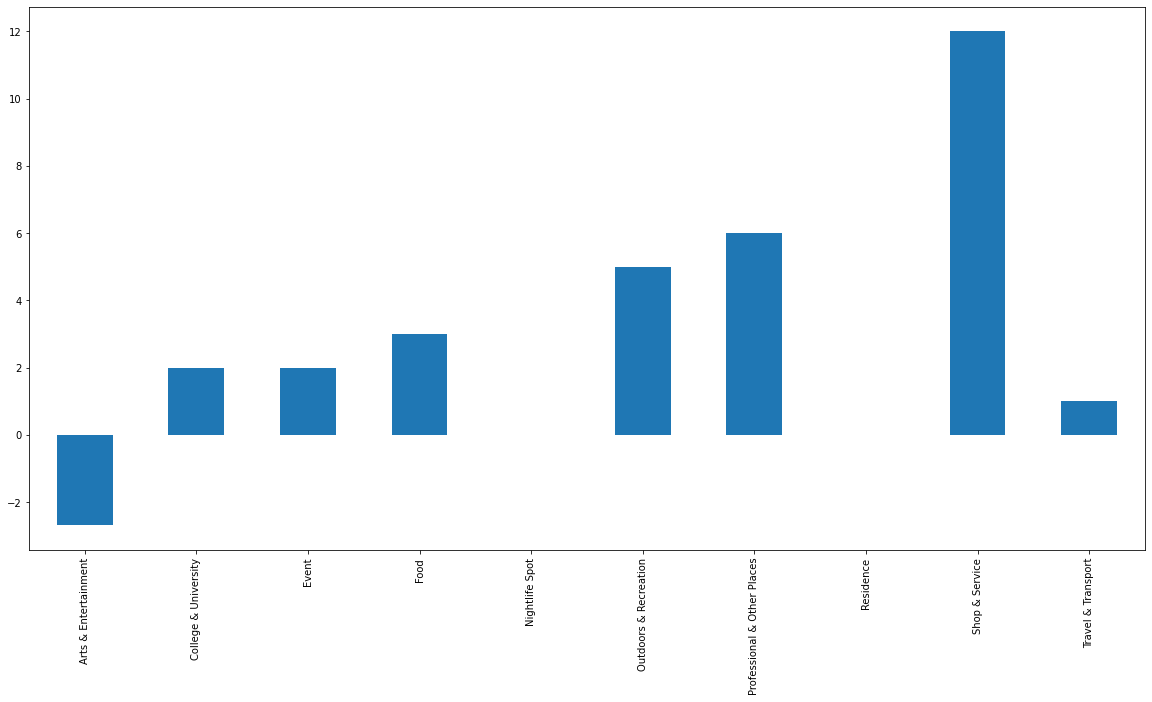

In [15]:
category_size = [36, 23, 12, 91, 7, 62, 41, 5, 145, 34]
category_start = [sum(category_size[:index]) for index in range(len(category_size))]
category_start.append(len(categories))
#histogram of subcategories on best neigboorhood
bestcluster_mean=goodcluster.groupby('Cluster').mean()
histogram=pd.DataFrame()
for i in range(len(category_size)):
    name=results[i]['name']
    count=bestcluster_mean.iloc[0,2+category_start[i]:2 + category_start[i+1]].sum()
    histogram[name]=[count]
histogram.iloc[0,:].plot(kind='bar',figsize=(20,10))
plt.show()

